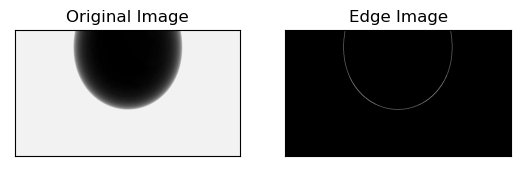

True

In [150]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt

img = cv2.imread('test.jpeg', cv2.IMREAD_GRAYSCALE)

edges = cv2.Canny(img,0,100)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()
cv2.imwrite('edges.jpeg', edges)

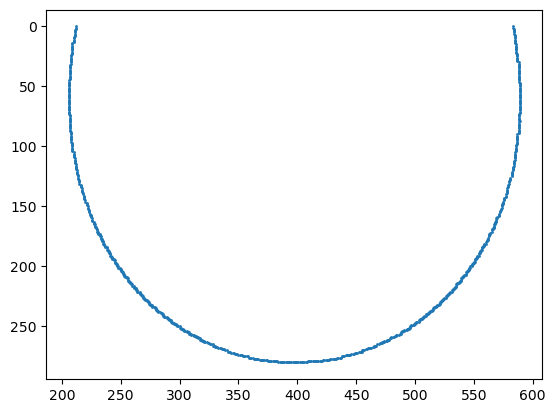

In [148]:
# Load the Canny edge detector output
canny_output = cv2.imread('edges.jpeg', cv2.IMREAD_GRAYSCALE)

# Set a threshold value for the edges
threshold = 100

# Get a binary image of the edges using the threshold value
edges = np.zeros_like(canny_output)
edges[canny_output > threshold] = 255

# Get the coordinates of all edge pixels
edge_pixels = np.transpose(np.nonzero(edges))

# Plot the edge pixels
fig, ax = plt.subplots()
ax.scatter(edge_pixels[:, 1], edge_pixels[:, 0], s=1)
ax.invert_yaxis()
plt.show()


In [154]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network
class EdgeNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(EdgeNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.transpose(x, 0, 1) # Transpose input to (1, 1736)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the loss function
criterion = nn.MSELoss()

# Load the edge coordinates and interfacial tension values
edges = edge_pixels
tensions = np.array(80)

# Flatten the edge coordinates
edges_flat = edges.flatten().reshape(-1, 1)  # reshape into (n_edges, 2) array

# Normalize the edge coordinates
edges_flat = (edges_flat - edges_flat.mean(axis=0)) / edges_flat.std(axis=0)

# Convert the data to PyTorch tensors
edges_flat_tensor = torch.from_numpy(edges_flat).float()  # add batch dimension
tensions_tensor = torch.from_numpy(tensions).float()  # add batch dimension

# Define the neural network architecture
input_size = edges_flat.shape[0]
hidden_size = 10
output_size = 1
model = EdgeNet(input_size, hidden_size, output_size)

# Define the optimizer
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train the neural network
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(edges_flat_tensor)
    loss = criterion(outputs, tensions_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Save the trained model
torch.save(model.state_dict(), 'edge_net.pt')



Epoch [100/1000], Loss: 137.1732
Epoch [200/1000], Loss: 2.4126
Epoch [300/1000], Loss: 0.0424
Epoch [400/1000], Loss: 0.0007
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000


In [153]:
model = EdgeNet(input_size, hidden_size, output_size)
model.load_state_dict(torch.load('edge_net.pt'))

output = model(edges_flat_tensor)
print(output.detach().numpy()[0][0])

79.99982
